<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B52)_Output%EC%9D%84_displacement%EB%A1%9C_%EC%88%98%EC%A0%95%ED%95%9C_%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

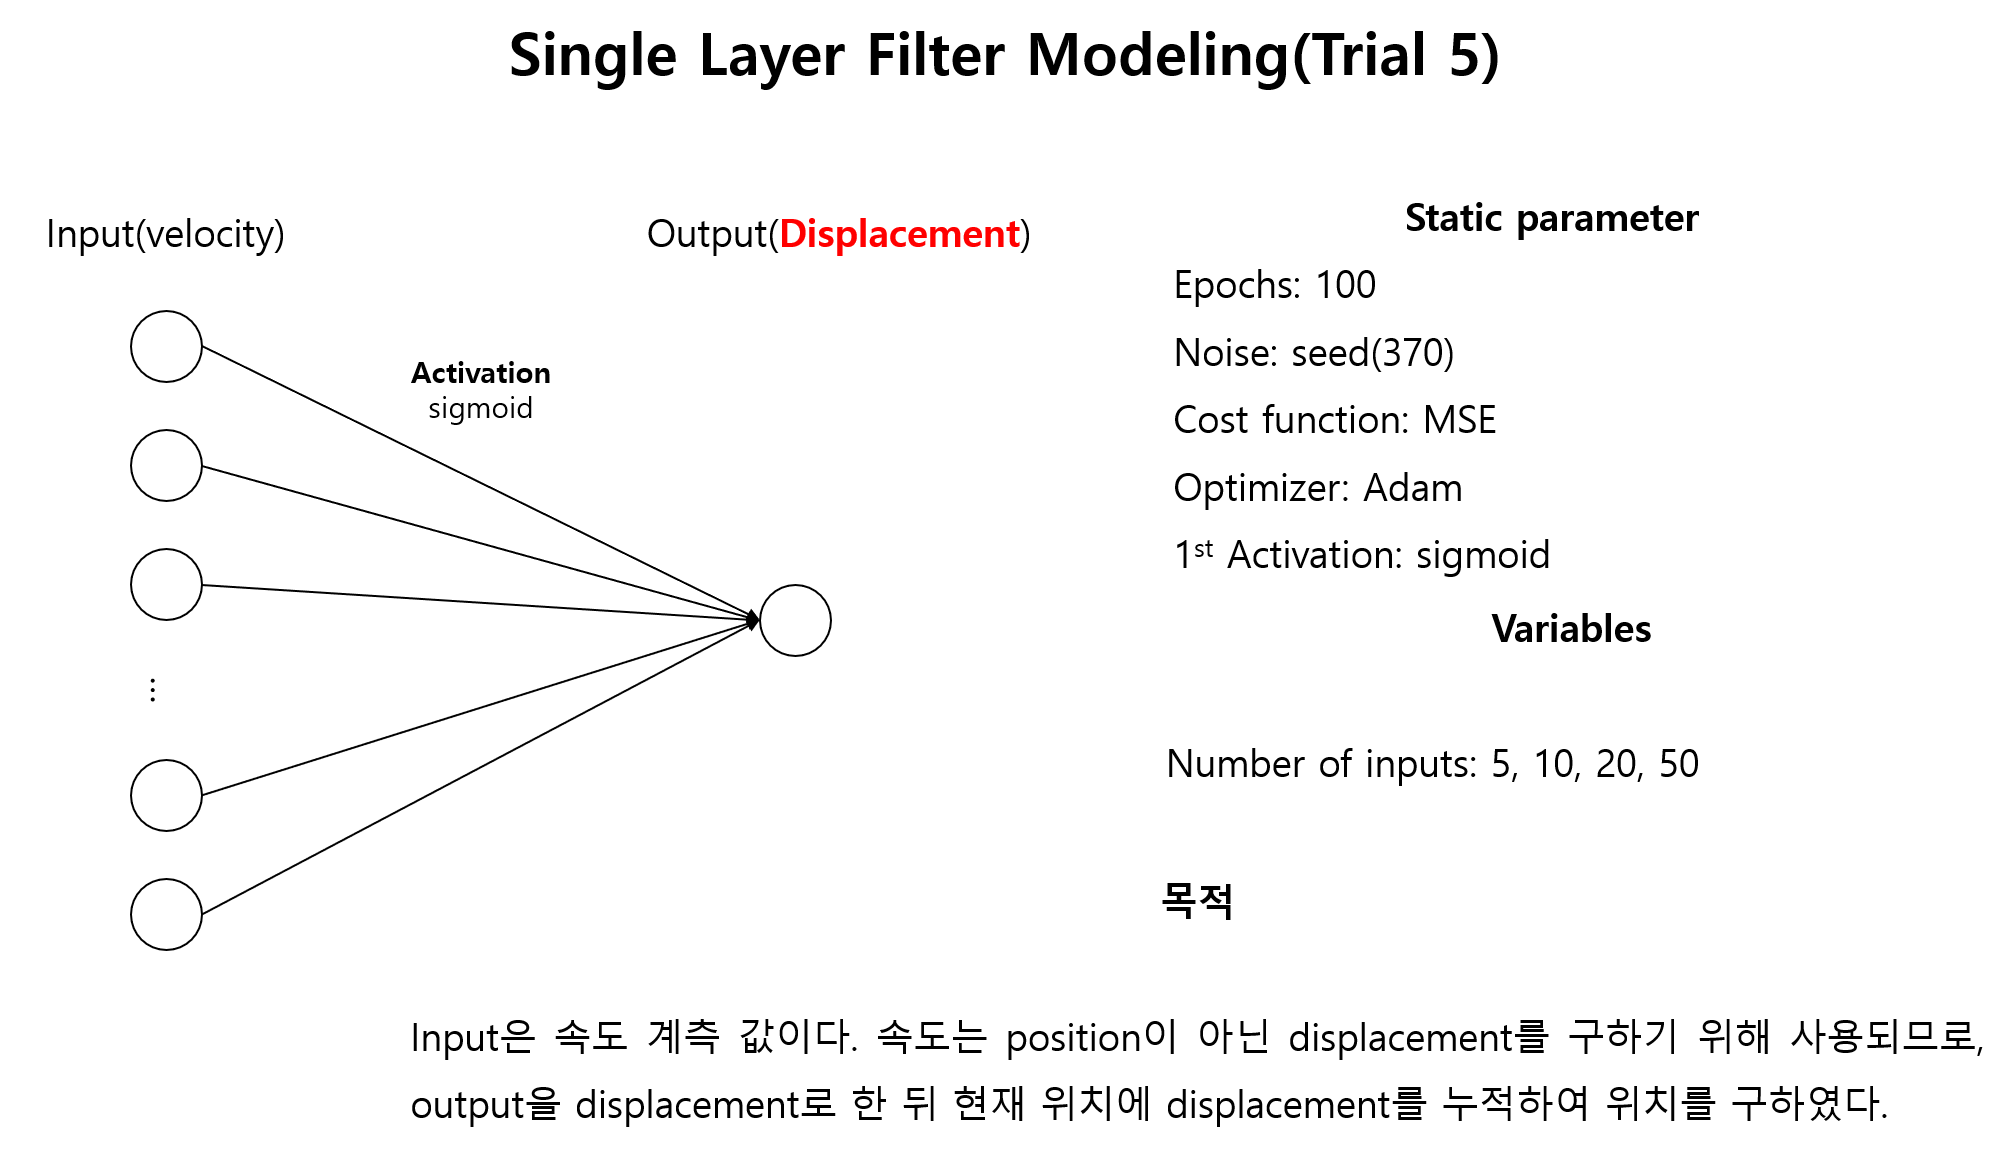

In [30]:
import numpy as np
import matplotlib.pyplot as plt

A,B, C = np.zeros((2,2)), np.zeros((2,1)), np.zeros((1,2))

#실험 조건, 데이터 사이즈 설정

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))
dx = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping

#정규분포 노이즈 생성
np.random.seed(370)
w, n = np.random.randn(1,N), np.random.randn(1,N)

# X행렬 구성성분
A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

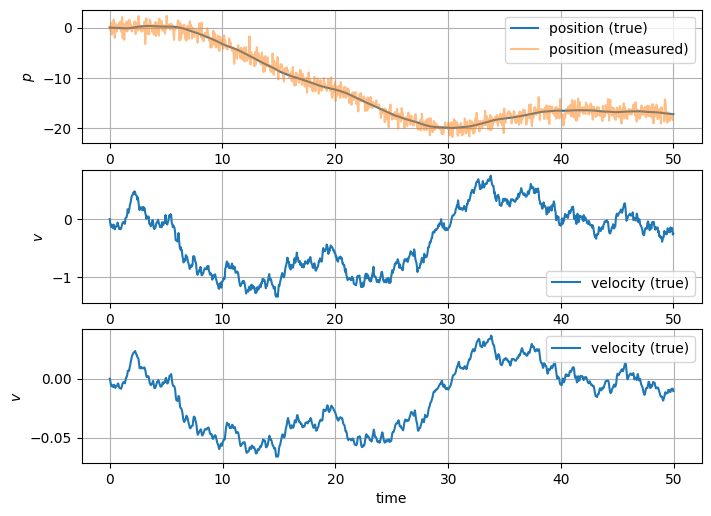

In [33]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])


for t in range(N-1):
    #displacement 추가 
    #현재 변위 = 현재 위치 - 방금 전 위치
    dx[:,t+1] = x[0,t+1] - x[0,t]
    

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(3,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
#displacement는 velocity와 모양이 같다. (속도에 증분을 곱한 것 이므로)
plt.subplot(3,1,3)
plt.plot(ts[:-1],dx[0,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

# 학습에 사용할 input의 사이즈 지정

DS = 50 부터 실행

<Figure size 800x300 with 0 Axes>

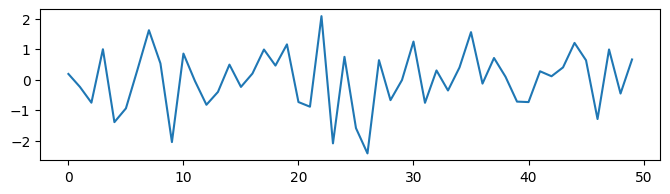

In [88]:
#학습할 데이터 사이즈(number of inputs)
DS = 50

train_input = np.zeros((1,DS))
#데이터 사이즈 만큼 계측 데이터 Y를 불러옴
plt.figure(figsize=(8,3), dpi=100)

train_input = y[:,:DS].copy()
#target 지정
train_target = np.array([dx[0,DS]])
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_input, train_target,epochs = 100)

In [120]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


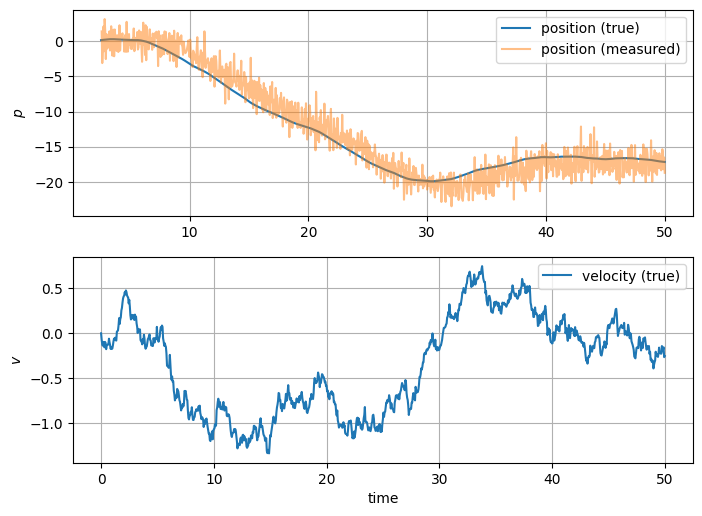

In [124]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

정확도는 좋아졌지만, 변위를 학습시켰는데 위치값이 나와서 난감하다.

학습한 변위의 target 데이터가 하나 뿐이라 변위인지 위치인지 구분을 못했던 듯

아래와 같이 변위로 취급한다면

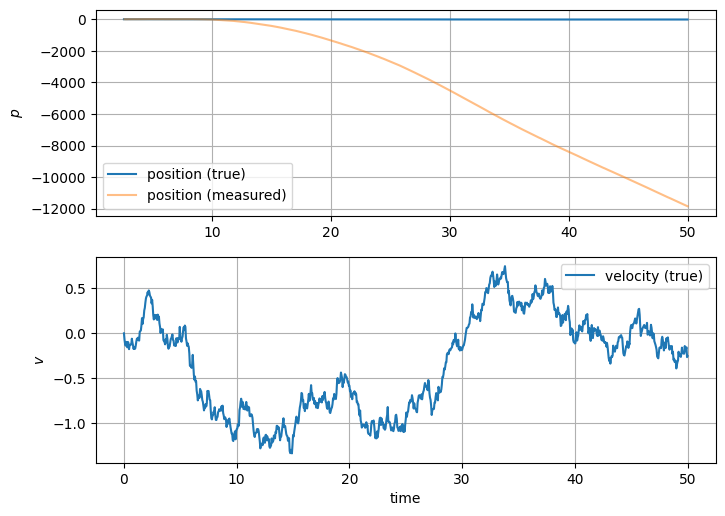

In [130]:
output = np.reshape(output,(1,1000))
pos = np.zeros((1,1000))

for i in range(N-1):
  pos[0,i+1]=pos[0,i]+output[0,i]

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

AI는 해당 값을 변위가 아닌 위치로 인식했던 듯
의도와는 다르지만 Data의 크기를 바꿔가며 실험을 계속해본다.

DS = 20

<Figure size 800x300 with 0 Axes>

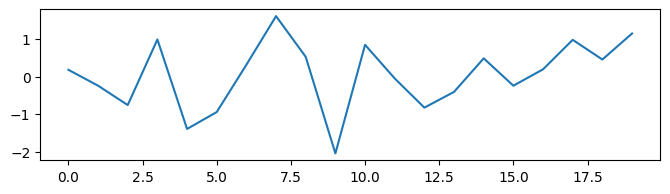

In [131]:
#학습할 데이터 사이즈(number of inputs)
DS = 20
train_input = np.zeros((1,DS))
plt.figure(figsize=(8,3), dpi=100)
train_input = y[:,:DS].copy()
train_target = np.array([dx[0,DS]])
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [132]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_input, train_target,epochs = 100)

In [134]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


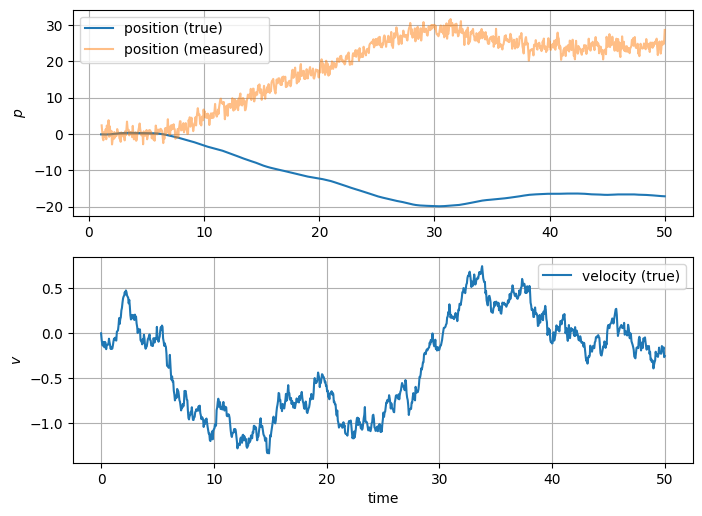

In [135]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

<Figure size 800x300 with 0 Axes>

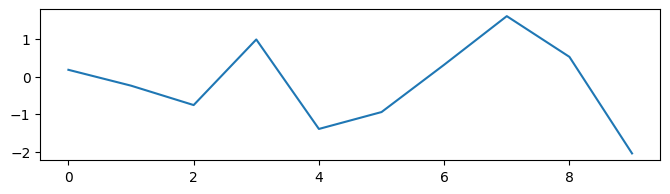

In [136]:
#학습할 데이터 사이즈(number of inputs)
DS = 10
train_input = np.zeros((1,DS))
plt.figure(figsize=(8,3), dpi=100)
train_input = y[:,:DS].copy()
train_target = np.array([dx[0,DS]])
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [137]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_input, train_target,epochs = 100)

In [139]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent


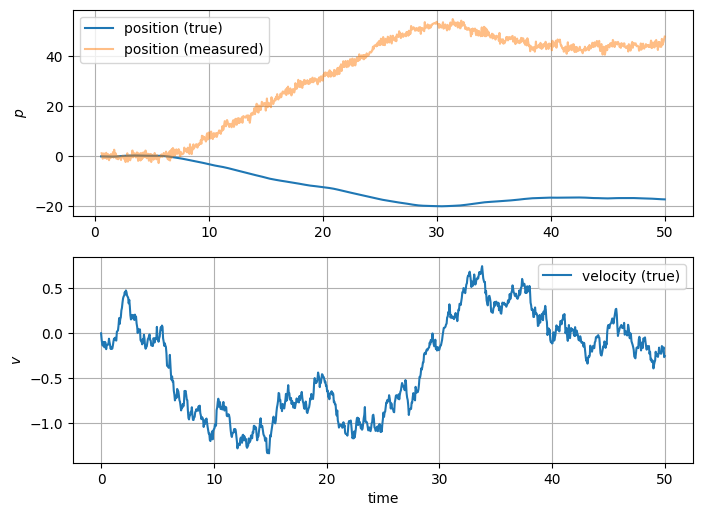

In [140]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

<Figure size 800x300 with 0 Axes>

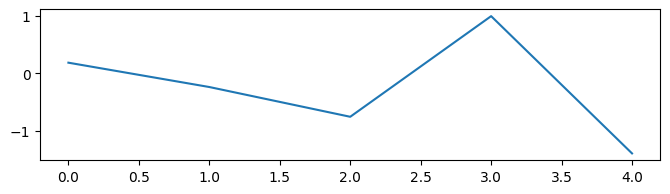

In [141]:
#학습할 데이터 사이즈(number of inputs)
DS = 5
train_input = np.zeros((1,DS))
plt.figure(figsize=(8,3), dpi=100)
train_input = y[:,:DS].copy()
train_target = np.array([dx[0,DS]])
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [142]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_input, train_target,epochs = 100)

In [ ]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

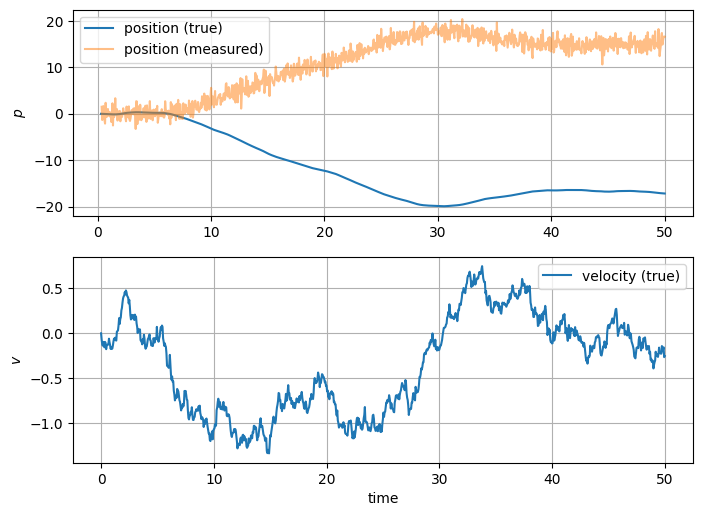

In [145]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

반대로 늘려보면 어떨까?

<Figure size 800x300 with 0 Axes>

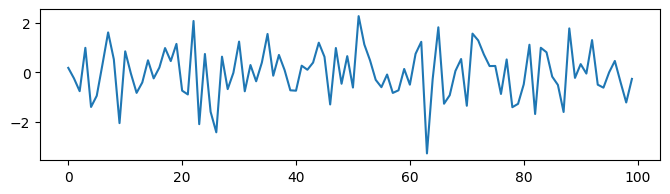

In [146]:
#학습할 데이터 사이즈(number of inputs)
DS = 100
train_input = np.zeros((1,DS))
plt.figure(figsize=(8,3), dpi=100)
train_input = y[:,:DS].copy()
train_target = np.array([dx[0,DS]])
plt.figure(figsize=(8,2), dpi=100)
plt.plot(train_input[0,:])
plt.show()

In [147]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, input_dim=DS)
])

model.compile(optimizer = "adam",
              loss = 'mse',
              metrics=['mae','mse'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.fit(train_input, train_target,epochs = 100)

Epoch 1/100
1/1 [==============================] - 0s 325ms/step - loss: 0.3442 - mae: 0.5867 - mse: 0.3442
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.2544 - mae: 0.5044 - mse: 0.2544
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1786 - mae: 0.4226 - mse: 0.1786
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.1169 - mae: 0.3419 - mse: 0.1169
Epoch 5/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0691 - mae: 0.2629 - mse: 0.0691
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.0348 - mae: 0.1866 - mse: 0.0348
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.0130 - mae: 0.1139 - mse: 0.0130
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0021 - mae: 0.0461 - mse: 0.0021
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 2.3873e-04 - mae: 0.0155 - mse: 2.3873e-04
Epoch 10/100
1/1 [==================

In [149]:
input = np.zeros((1,DS))
output = np.zeros((1,1,DS))

for i in range(1000-DS):
  input = y[:,i:DS+i].copy()
  output=np.append(output,model.predict(input))
  if i%100==0:
    print("%.1f percent" %(i/10))

0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent


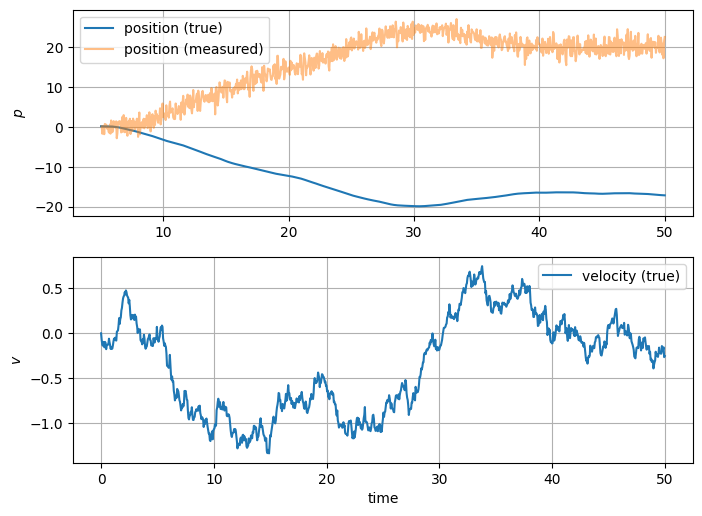

In [150]:
output = np.reshape(output,(1,1000))

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

 결국 모델이 변위를 위치값으로 인식한 듯 하다,
 오차는 개선되지 않는 것으로 보아 DS = 50에서의 값이 운이 좋았던듯